In [1]:
import csv
import numpy as np
import os
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import ticker
from scipy.stats import spearmanr
from torch.utils.tensorboard import SummaryWriter

import Plotting 
import datetime
import Dataloader
import seaborn as sns

In [2]:
seed=999
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)



cuda:0


In [4]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"

In [5]:
df=pd.read_csv(fname)

In [6]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0


In [7]:
df["tau"]=df["Lr"]/(df["Lr"]+df["Lc"])
df["Xc"]=df["Lc"]/df["Nc"]
d=df[['Lc','Nc','Lr','Nr','lwc0','rm','nu_gam','tau','Xc']].to_numpy()
time=df['time']
input_num=d.shape[-1]

In [8]:
timestep,dataset=Dataloader.create_dataset_updatefunc(d, time)

In [79]:
dataset[:,0]

array([   20.,    40.,    60., ..., 10420., 10440., 10460.])

In [9]:
sns.set_theme()

In [10]:
time=dataset[:,0]
sim_info=[]
initial_loc=0

for t in range (0,len(time)-1):
    if time[t+1]<time[t]:
        end_loc=t
        sim_duration=time[end_loc]-time[initial_loc]
        sim_info.append(np.array([initial_loc,end_loc,sim_duration]))
        initial_loc= t+1
      

In [11]:
Lr_info=[]
model_info=[]
for n in range (len(sim_info)):
    
    Lr_sim=dataset[int(sim_info[n][0]):int(sim_info[n][1]),4]
    max_lr=np.max(Lr_sim)
    Lr_pos=np.asarray(np.where(Lr_sim==max(Lr_sim)))+np.asarray(sim_info[n][0])
    Lr_info.append(np.asarray([max_lr,Lr_pos]))
    model_info.append(dataset[int(sim_info[n][0]),5:8])

/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
Lr_info=np.asarray(Lr_info)

In [13]:
model_info=np.asarray(model_info)

Text(0.5, 1.0, '')

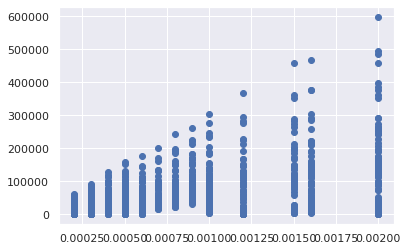

In [14]:
plt.scatter(model_info[:,0],Lr_info[:,0])
plt.title("")

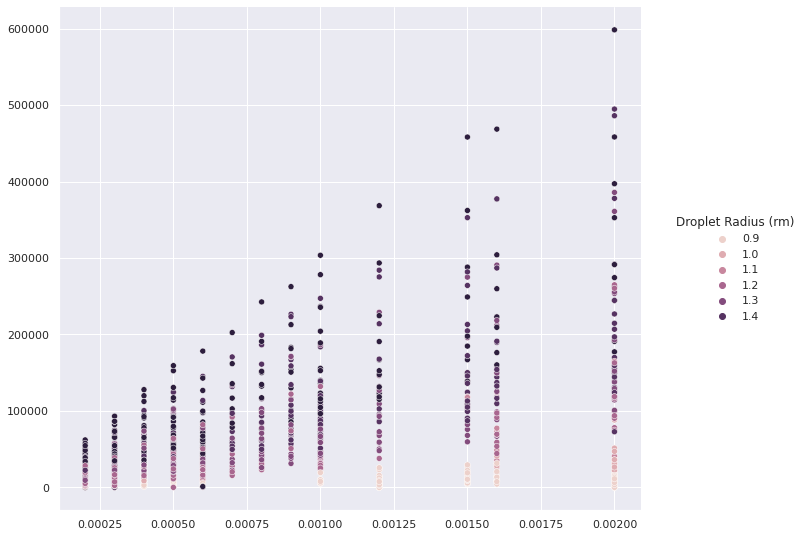

In [26]:

g=sns.relplot(x=model_info[:,0], y=Lr_info[:,0], hue=model_info[:,1])
g.fig.set_figwidth(10)
g.fig.set_figheight(8)
g.legend.set_title("Droplet Radius (rm)")
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((1.2, .6))

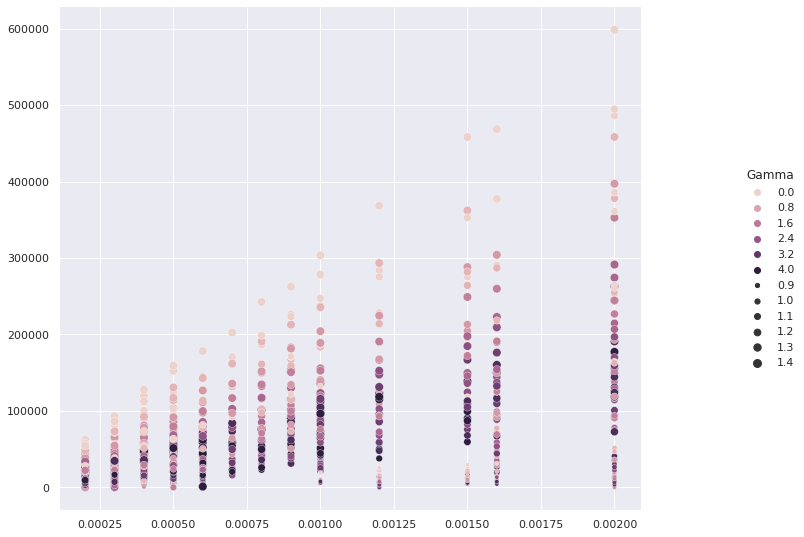

In [29]:
g=sns.relplot(x=model_info[:,0], y=Lr_info[:,0], hue=model_info[:,2],size=model_info[:,1])
g.fig.set_figwidth(10)
g.fig.set_figheight(8)
g.legend.set_title("Gamma")
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((1.2, .6))

In [42]:
x_data=torch.tensor(model_info)
y_data=Lr_info[:,0].astype(np.float32)
y_data=torch.from_numpy(y_data)

In [41]:
class LinearRegressionModel(torch.nn.Module):
  
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(3, 1)  # Three in and one out
  
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred